In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt

%matplotlib inline
%precision 3

'%.3f'

In [2]:
class G:
    base_dir = os.path.abspath(join(".."))
    data_dir = os.path.abspath(join("..", "data"))

In [3]:
train_df = pd.read_csv(join(G.data_dir, "train_data.csv"), header=0, sep=",")

features = {"predictors": ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'],
            "target": "is_developer"}

xx_data = train_df[features["predictors"]].as_matrix()
yy_data = train_df[features["target"]].as_matrix()
print("positive percentage: {}".format(sum(yy_data) / len(yy_data)))

positive percentage: 0.134


In [10]:
from numpy.random import choice

n_obs = xx_data.shape[0]
sample_idx = choice([True, False], size=n_obs, replace=True, p=[0.8, 0.2])

xx_train, xx_test = xx_data[sample_idx], xx_data[~sample_idx]
yy_train, yy_test = yy_data[sample_idx], yy_data[~sample_idx]

In [13]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier()
boost.fit(xx_train, yy_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

LogisticModel = LogisticRegression(penalty='l1', C=0.1, max_iter=1000)
Boosting = AdaBoostClassifier()
RF = RandomForestClassifier()
SVM = SVC( probability=True)

classifiers = {"Logistic Regression (L1: Lasso)": LogisticModel, 
               "SVM (Kernel=RDF)": SVM,
               "Boosting Tree": Boosting, 
               "Random Forest": RF}

In [118]:
train_reports, test_reports = model_selection_cv(classifiers, xx_data, yy_data, k=10, eval_func=classifier_evaluator)

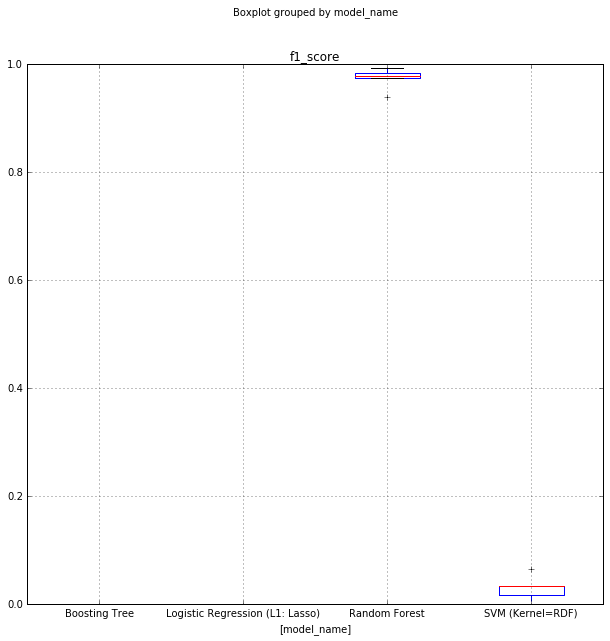

In [140]:
test_reports.ix[:, ["f1_score", "model_name"]].boxplot(by=["model_name"], figsize=(10, 10))

In [141]:
test_reports

,model_name,accuracy,f1_score,precision,roc_auc,sensitivity,specificity
0,Random Forest,0.993326,0.974359,1,0.999914,0.950000,1
1,Random Forest,0.995551,0.983051,1,0.999968,0.966667,1
2,Random Forest,0.993326,0.974359,1,1.000000,0.950000,1
3,Random Forest,0.995551,0.983051,1,0.999979,0.966667,1
4,Random Forest,0.984444,0.938596,1,0.999979,0.884298,1
5,Random Forest,0.993333,0.974576,1,0.999947,0.950413,1
6,Random Forest,0.997780,0.991667,1,0.999979,0.983471,1
7,Random Forest,0.993341,0.974576,1,0.999989,0.950413,1
8,Random Forest,0.996670,0.987448,1,1.000000,0.975207,1
9,Random Forest,0.994451,0.978903,1,0.999936,0.958678,1
